In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from math import log

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
GOOGLE_DIR_FOLDER = '/content/drive/MyDrive/cs584'
BCCC_NAME = 'bccc-cpacket-cloud-ddos-2024-merged.parquet'

In [ ]:
bccc_cpacket = pd.read_parquet(f'{DIR_FOLDER}/{BCCC_NAME}')

In [ ]:
#clean data
def clean():
  #drop rows with empty data, but no rows seem to be empty
  #print(bccc_cpacket.shape)
  bccc_wdropped = bccc_cpacket.dropna(inplace=False)
  #print(bccc_wdropped.shape)

  #remove rows that are suspcious

  sus_removed =  bccc_wdropped[bccc_wdropped['label'] != 'Suspicious']

  #remove rows that only have 1 unique value
  #bwd_urg_flag_counts, bwd_urg_flag_percentage_in_total, bwd_urg_flag_percentage_in_bwd_packets
  one_unique_features = []
  for feature in sus_removed.columns.values:
    if len(sus_removed[feature].unique()) == 1:
      one_unique_features.append(feature)
  one_unique_removed = sus_removed.drop(columns=one_unique_features)


  #identify the categorical features : src_port and dst_port
  #label is the output
  #everything else is a continuous numeric value

  #activity column will still be removed because I believe that it is another output
  activity_removed = one_unique_removed.drop(columns=['activity'])

  #one-hot encoding on src_port and dst_port
  dataset_encoded = pd.get_dummies(activity_removed, columns=['src_port', 'dst_port'])
  print(dataset_encoded.shape)



clean()

In [ ]:
bccc_cpacket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540494 entries, 0 to 540493
Columns: 319 entries, src_port to activity
dtypes: float32(261), int16(9), int32(20), int64(2), int8(25), object(2)
memory usage: 618.0+ MB


In [ ]:
def cross_entropy_loss(y_true, log_proba, columns):
  summation = 0
  for i in range(len(y_true)):
    c = y_true.iat[i]
    index = columns.index(c)
    summation += log_proba[i][index]
  return (0 - summation)/len(y_true)

In [ ]:
def pearson_correlation_coefficient(x, y):
  avg = lambda a : sum(a)/len(a)
  sst = lambda a, a_bar : sum([(ai - a_bar) ** 2 for ai in a])

  x_bar = avg(x)
  y_bar = avg(y)

  x_sst = sst(x, x_bar)
  y_sst = sst(y, y_bar)

  numerator = sum([(xi - x_bar) * (yi - y_bar) for xi, yi in zip(x, y)])
  denominator = (x_sst * y_sst) ** 0.5

  return numerator/denominator

In [ ]:
def find(feature, parent_list):
      if parent_list[feature]['parent'] == feature:
        return feature
      else:
        result = find(parent_list[feature]['parent'], parent_list)
        parent_list[feature]['parent'] = result
        return result

def union(i, j, parent_list):
      i_parent = find(i, parent_list)
      j_parent = find(j, parent_list)

      if i_parent == j_parent:
        pass

      i_rank = parent_list[i_parent]['rank']
      j_rank = parent_list[j_parent]['rank']

      if i_rank < j_rank:
        parent_list[i_parent]['parent'] = j_parent
      elif i_rank > j_rank:
        parent_list[j_parent]['parent'] = i_parent
      else:
        parent_list[i_parent]['parent'] = j_parent
        parent_list[j_parent]['rank'] += 1

In [ ]:
def run_random_forest(correlation_threshold=1.0, remove_suspicious=True, normalize=True, random_sample_testing=False, criterion='entropy'):
  #find rows with empty duration
  rows_with_zero_duration = []
  for i in range(len(bccc_cpacket)):
    if bccc_cpacket['duration'][i] == 0:
      rows_with_zero_duration.append(i)

  #remove rows with empty duration
  data = bccc_cpacket.drop(rows_with_zero_duration, axis='index', inplace=False)

  #find any columns with only one unique value
  one_value_columns = []
  for col_name in data.columns:
    if len(data[col_name].unique()) == 1:
      one_value_columns.append(col_name)

  #remove columns with one unique value
  data.drop(one_value_columns, axis='columns', inplace=True)

  #remove activity column -- feels redundant with label
  data.drop(['activity'], axis='columns', inplace=True)


  if remove_suspicious:
    #find rows with label of suspicious
    rows_with_suspicious = []
    for index, row in data[['label']].itertuples():
      if row == 'Suspicious':
        rows_with_suspicious.append(index)

    data.drop(rows_with_suspicious, axis='index', inplace=True)

  step = len(data)//5
  start_index = 0
  end_index = step

  for _ in range(5):
    if random_sample_testing:
      training_data = data.sample(frac=0.80)
      testing_data = data.drop(training_data.index, axis='index', inplace=False)

      training_data_X = training_data.drop(['label'], axis='columns', inplace=False)
      training_data_Y = training_data['label']

      testing_data_X = testing_data.drop(['label'], axis='columns', inplace=False)
      testing_data_Y = testing_data['label']
    else:
      testing_data_X = data[start_index:end_index].drop(['label'], axis='columns', inplace=False)
      testing_data_Y = data[start_index:end_index]['label']

      training_data_X = data.drop(testing_data_X.index, axis='index', inplace=False).drop(['label'], axis='columns', inplace=False)
      training_data_Y = data.drop(testing_data_X.index, axis='index', inplace=False)['label']

    parent_list = {feature : {'parent': feature, 'rank': 0} for feature in training_data_X.columns}

    if normalize:
      #normalize training data
      scaler = StandardScaler()
      training_data_X = pd.DataFrame(scaler.fit_transform(training_data_X), columns=training_data_X.columns)

    corr_matrix = training_data_X.corr('pearson')
    #print(corr_matrix.loc['src_port']['src_port'])
    for row_label in corr_matrix.index:
      for col_label in corr_matrix.columns:
        if row_label == col_label:
          pass
        elif abs(corr_matrix.loc[row_label][col_label]) >= correlation_threshold:
          union(row_label, col_label, parent_list)

    good_features = set([x['parent'] for x in parent_list.values()])
    #print(good_features)

    training_data_X = training_data_X[list(good_features)]
    #print(len(training_data_X.columns))
    #print(training_data_X)
    testing_data_X = testing_data_X[list(good_features)]

    #print(training_data_X)
    #print(len(test))
    #print(test)

#    #correlation wipe
#    correlation_coefficient_dic = {}
#    for i in training_data_X.columns:
#      for j in training_data_X.columns:
#        if i != j:
#          if (i, j) not in correlation_coefficient_dic and (j, i) not in correlation_coefficient_dic:
#            try:
#              correlation_coefficient_dic[(i,j)] = pearson_correlation_coefficient(training_data_X[i], training_data_X[j])
#            except:
#              correlation_coefficient_dic[(i,j)] = 0

#    #high corrleation coefficient features
#    high_correlation_features = []
#    for key, value in correlation_coefficient_dic.items():
#      if abs(value) >= correlation_threshold:
#        high_correlation_features.append(key)

#    #find number of unique feature names in high_correlation_feature list
#    high_correlation_feature_names = set()
#    for a, b in high_correlation_features:
#      high_correlation_feature_names.add(a)
#      high_correlation_feature_names.add(b)

    #print(high_correlation_feature_names)
    #print(len(high_correlation_feature_names))







#    for a, b in high_correlation_features:
#      union(a, b)

#    parent_children_dic = {}

#    for child, value in parent_list.items():
#      if child == value['parent']:
#        pass
#      elif value['parent'] not in parent_children_dic:
#        parent_children_dic[value['parent']] = [child]
#      else:
#        parent_children_dic[value['parent']].append(child)

    #get all unnessesary children
#    children_lst = []
#    for children in parent_children_dic.values():
#      children_lst += children
#    children_lst = set(children_lst)

#    data.drop(list(children_lst), axis='columns', inplace=True)

    #fit to model
    clf = RandomForestClassifier(criterion=criterion)
    clf.fit(X=training_data_X, y=training_data_Y)
#    print(clf.predict_proba(testing_data_X))
    ConfusionMatrixDisplay.from_estimator(clf, testing_data_X, testing_data_Y)
    plt.show()
    RocCurveDisplay.from_estimator(clf, testing_data_X, testing_data_Y)
    plt.show()


    #true
    print(clf.score(X=testing_data_X, y=testing_data_Y))
    #predictions = clf.predict(X=testing_data_X)
    print(cross_entropy_loss(testing_data_Y, clf.predict_log_proba(testing_data_X), clf.classes_.tolist()))

    #print(confusion_matrix(testing_data_Y, clf.predict(testing_data_X)))

    start_index += step
    end_index += step


In [ ]:
run_random_forest(correlation_threshold=0.90, remove_suspicious=True, random_sample_testing=False)

0.9998495976737773
0.3924355704971874
1.0
0.2304106727713755
1.0
0.21615057713960412
0.6161732634798085
0.5695701206461515
0.8019953375278871
0.5573329344943273


In [ ]:
run_random_forest(correlation_threshold=0.1, remove_suspicious=True, random_sample_testing=False)

{'dst_port', 'active_skewness'}
1.0
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


{'dst_port'}
0.9998245306194069


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.00012744518140790984
{'dst_port'}
1.0
4.58817581359696e-06


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


{'dst_port'}
0.6161732634798085


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


inf
{'dst_port'}
0.8018950693104053
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [ ]:
run_random_forest(correlation_threshold=0.1, remove_suspicious=True, random_sample_testing=True)

0.8840677796159824
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8815360705870557
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8847445731187648
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8826139269063017
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8841429788940692
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [ ]:
run_random_forest(c)

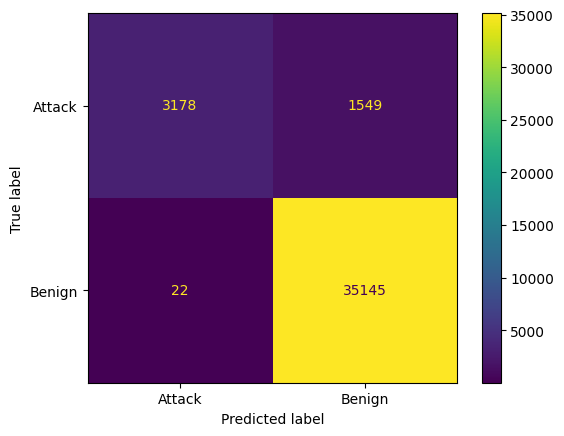

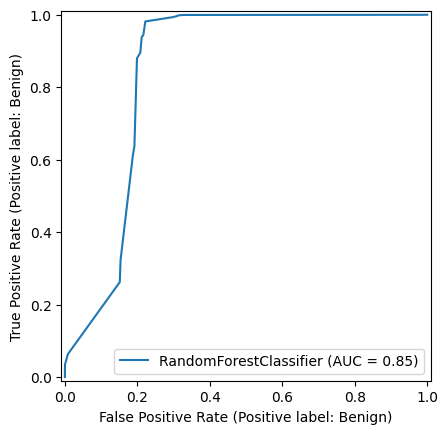

0.9606206447084774
0.3557482994427883


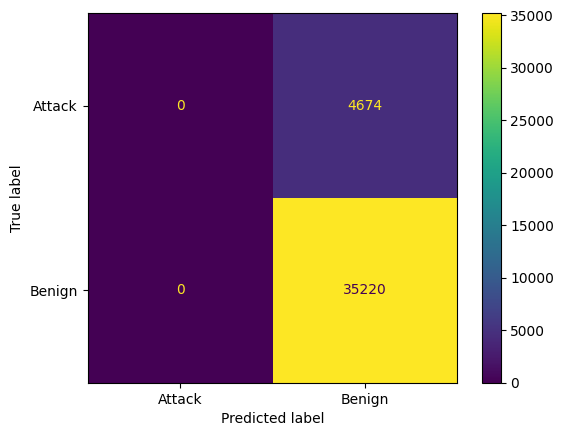

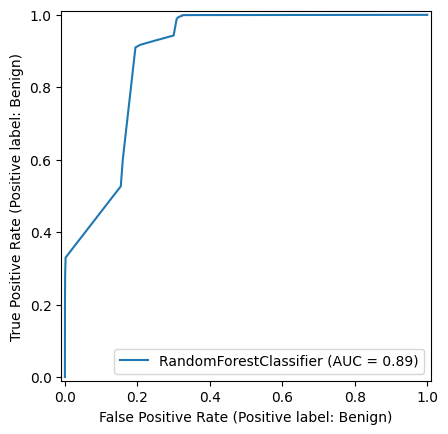

0.8828395247405625
0.3710713968370603


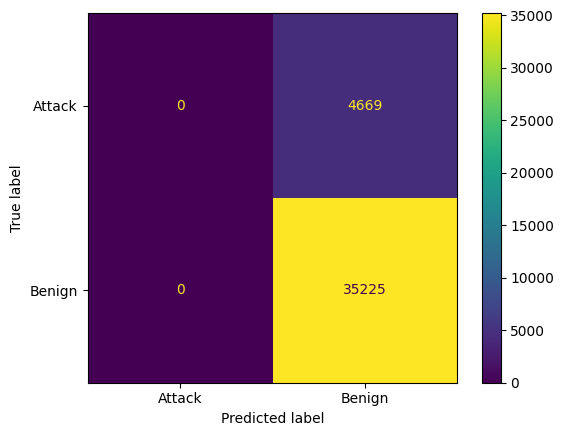

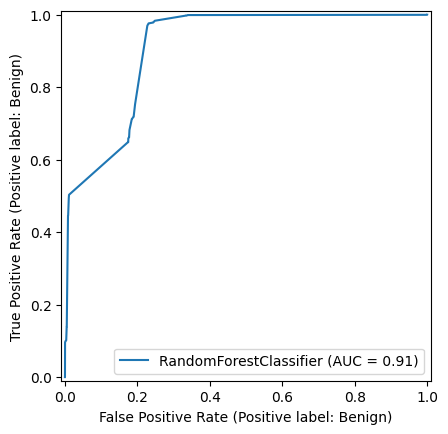

0.8829648568707074
0.3879830957820939


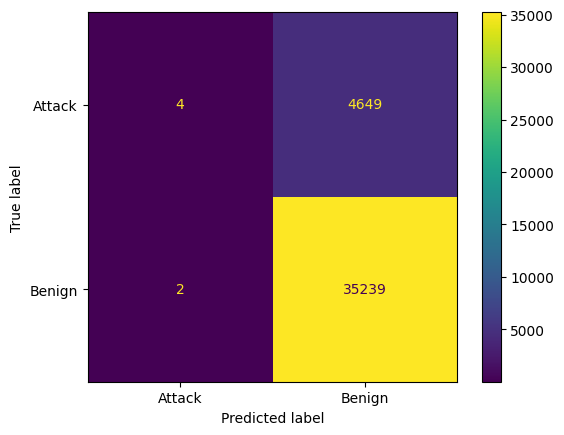

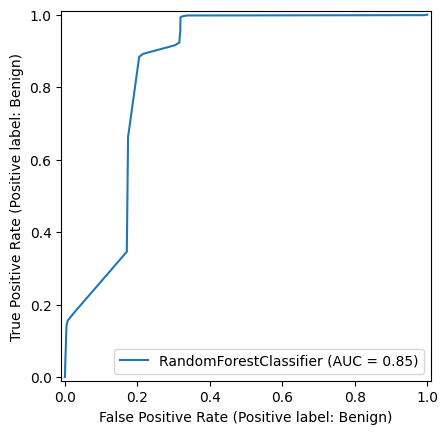

0.883416052539229
0.395959876948453


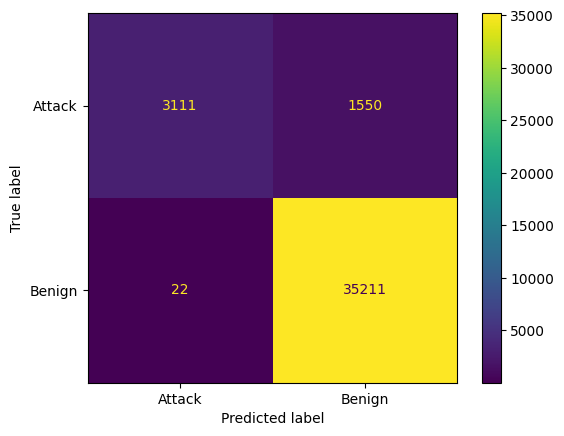

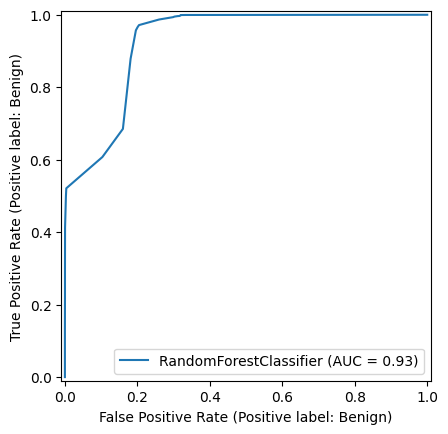

0.9605955782824485
0.3660086957049853


In [ ]:
run_random_forest(remove_suspicious=True, random_sample_testing=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


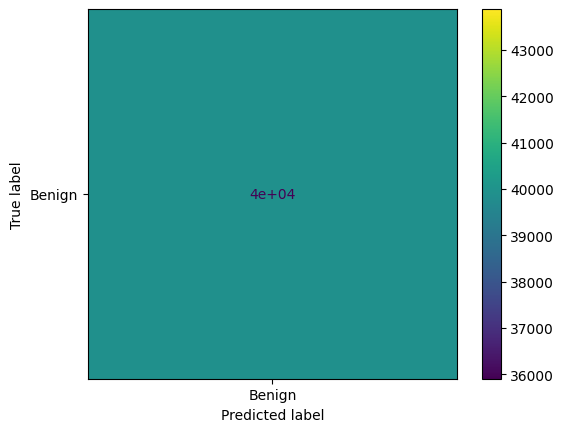

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


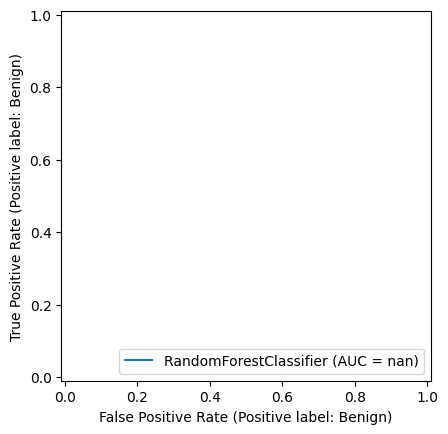

1.0
0.3070557254081829


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


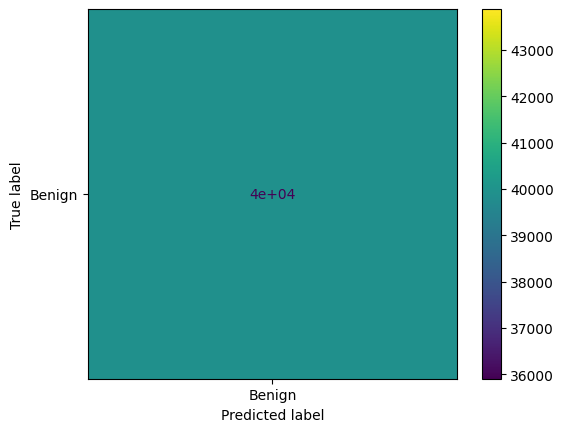

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


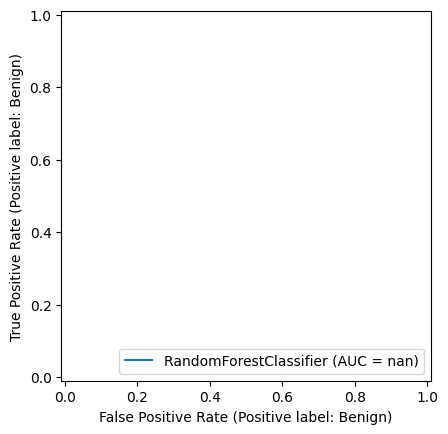

1.0
0.3353721639963644


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


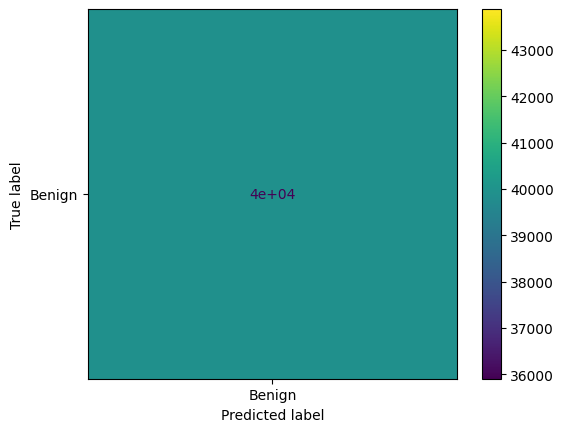

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


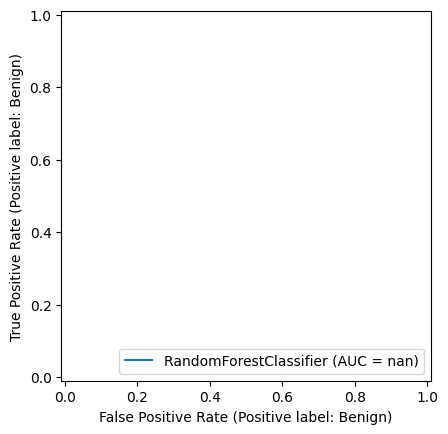

1.0
0.2858645293475709


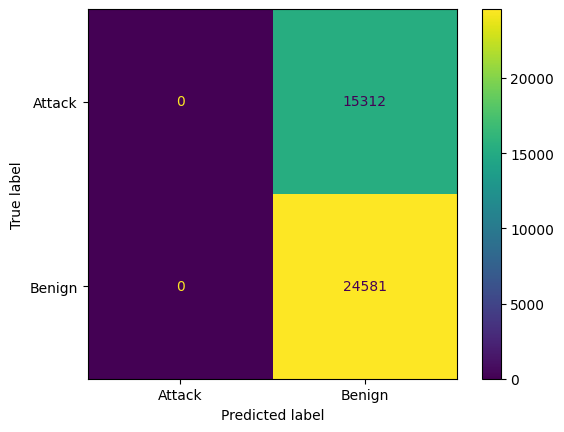

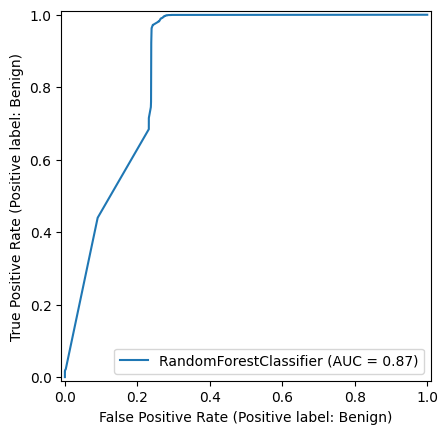

0.6161732634798085
0.5446913233731995


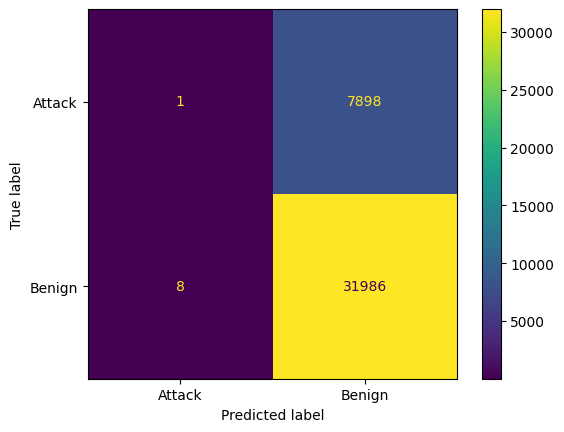

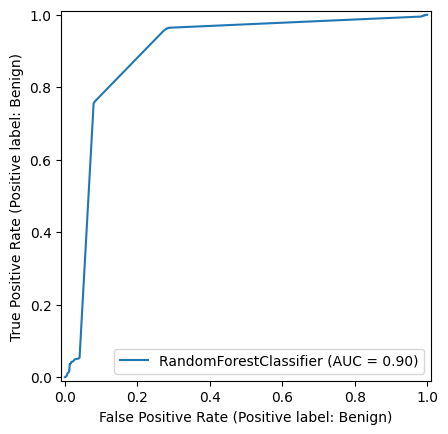

0.801819868147294
0.5223034870538142


In [ ]:
run_random_forest(remove_suspicious=True, random_sample_testing=False)

In [ ]:
run_random_forest(correlation_threshold=0.80, remove_suspicious=True, random_sample_testing=True)

0.8836416503734897
0.3908528903478421
0.8836165839474608
0.3574059342379984
0.8859978944202136
0.31267220711547766
0.8807590113801574
0.37433768812372314
0.8848949716749386
0.4124900101179607


In [ ]:
run_random_forest(correlation_threshold=0.80, remove_suspicious=True, random_sample_testing=False)

1.0
0.2807407182213047
1.0
0.2643735911672215
1.0
0.20658690507143088
1.0
0.2046192155036094
1.0
0.23267728283183667


In [ ]:
run_random_forest(correlation_threshold=0.10, remove_suspicious=True, random_sample_testing=True)

0.8837920489296636
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8798816864691432


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


inf
0.8819621998295483
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8847195066927358
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


0.8851957687872863
inf


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [ ]:
run_random_forest(correlation_threshold=0.10, remove_suspicious=True, random_sample_testing=False)

1.0
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


1.0
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


1.0
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


1.0
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


1.0
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [ ]:
run_random_forest(remove_suspicious=True, random_sample_testing=False, criterion='gini')

0.9988970496077006
0.39839616817678414
0.9999749329456296
0.3639552386095725
0.9991978542601458
0.4555288681275984
0.9999749329456296
0.3792661972782239
1.0
0.38005207703427163


Column Names:

src_port
dst_port
duration
packets_count
fwd_packets_count
bwd_packets_count
total_payload_bytes
fwd_total_payload_bytes
bwd_total_payload_bytes
payload_bytes_max


In [ ]:
#info about data

n_rows = len(bccc_cpacket) #540494
column_list = bccc_cpacket #319


#remove columns consisting of only 1 value
one_value_columns = []
for column in column_list:
  if len(bccc_cpacket[column].unique()) == 1:
    #bwd_urg_flag_counts, bwd_urg_flag_percentage_in_total, #bwd_urg_flag_percentage_in_bwd_packets
    one_value_columns.append(column)

bccc_cpacket.drop(one_value_columns, axis='columns', inplace=True)
print(len(bccc_cpacket.columns)) #316 columns

#remove any packets with a duration a 0. Is this a good idea?
rows_with_zero_duration = []
duration_column = bccc_cpacket['duration']
for row_num in range(len(duration_column)):
  if duration_column[row_num] == 0:
    rows_with_zero_duration.append(row_num)

bccc_cpacket_removed_duration_zero = bccc_cpacket.drop(rows_with_zero_duration, axis='index', inplace=False).reset_index(inplace=False)
# print(bccc_cpacket_removed_duration_zero)
# print(len(bccc_cpacket_removed_duration_zero)) #210319








316


In [ ]:
#bccc_cpacket_removed_duration_zero.describe()

#remove any packets with a total_payload of 0 bytes
rows_with_no_payload = []
payload_column = bccc_cpacket_removed_duration_zero['total_payload_bytes']
for row_num in range(len(payload_column)):
  if payload_column[row_num] == 0:
    rows_with_no_payload.append(row_num)

bccc_cpacket_removed_duration_payload_zero = bccc_cpacket_removed_duration_zero.drop(rows_with_no_payload, axis='index', inplace=False).reset_index(inplace=False).drop(['level_0', 'index'], axis='columns', inplace=False)
#print(len(bccc_cpacket_removed_duration_payload_zero)) 2352



In [ ]:
print(bccc_cpacket_removed_duration_payload_zero)

      src_port  dst_port    duration  packets_count  fwd_packets_count  \
0        52956       443  195.348190             47                 35   
1        57716       443  120.165604             41                 19   
2        18466     21335    0.000068              3                  2   
3        18466     21335    0.000043              3                  1   
4        18466     21335    0.000035              3                  1   
...        ...       ...         ...            ...                ...   
2347     45849       445    0.621222              9                  5   
2348     45877       445    0.595488              5                  3   
2349     45986       445    0.411433              7                  4   
2350     59092        22    0.066151              3                  2   
2351     46751       445    0.205192              5                  3   

      bwd_packets_count  total_payload_bytes  fwd_total_payload_bytes  \
0                    12               

In [ ]:
#feature dataFrame of bccc_cpacket (without label or activity columns)
bccc_cpacket_removed_duration_payload_zero_features = bccc_cpacket_removed_duration_payload_zero.drop(['label', 'activity'], axis='columns', inplace=False)
#print(bccc_cpacket_removed_duration_payload_zero_features)
feature_list = bccc_cpacket_removed_duration_payload_zero_features.columns

#normalize data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(bccc_cpacket_removed_duration_payload_zero_features) #this may be wrong because now src and dst ports are a float
#print(normalized_features)

#put back in a datatable

normalized_table = pd.DataFrame(data=normalized_features, columns=feature_list)
#print(normalized_table)


In [ ]:
#calculate pearson correlation coefficient on features (they should all be nominal values)

correlation_coefficient_dic = {}
for i in feature_list:
  for j in feature_list:
    if i != j:
      if (i, j) not in correlation_coefficient_dic and (j, i) not in correlation_coefficient_dic:
        try:
          correlation_coefficient_dic[(i,j)] = pearson_correlation_coefficient(normalized_table[i], normalized_table[j])
        except:
          correlation_coefficient_dic[(i,j)] = 0




In [ ]:
#high corrleation coefficient features
high_correlation_features = []
max_value = 0
for key, value in correlation_coefficient_dic.items():
  if abs(value) >= 0.80:
    high_correlation_features.append(key)
  if value > max_value:
    max_value = value

print(max_value)

1.000000000000019


In [ ]:
#print(len(high_correlation_features)) #150 pairs of features have a correlation coefficient of 99% or higher
#print(high_correlation_features)

#perform union-find on pairs

#find number of unique feature names in high_correlation_feature list
high_correlation_feature_names = set()
for a, b in high_correlation_features:
  high_correlation_feature_names.add(a)
  high_correlation_feature_names.add(b)

#print(high_correlation_feature_names)
#print(len(high_correlation_feature_names))

parent_list = {feature : {'parent': feature, 'rank': 0} for feature in high_correlation_feature_names}

def find(feature):
  if parent_list[feature]['parent'] == feature:
    return feature
  else:
    result = find(parent_list[feature]['parent'])
    parent_list[feature]['parent'] = result
    return result

def union(i, j):
  i_parent = find(i)
  j_parent = find(j)

  if i_parent == j_parent:
    pass

  i_rank = parent_list[i_parent]['rank']
  j_rank = parent_list[j_parent]['rank']

  if i_rank < j_rank:
    parent_list[i_parent]['parent'] = j_parent
  elif i_rank > j_rank:
    parent_list[j_parent]['parent'] = i_parent
  else:
    parent_list[i_parent]['parent'] = j_parent
    parent_list[j_parent]['rank'] += 1

In [ ]:
for a, b in high_correlation_features:
  union(a, b)

#print(parent_list)

#number of parents
#parent_set = set()
#for value in parent_list.values():
#  parent_set.add(value)

#print(len(parent_set))



In [ ]:
parent_children_dic = {}

for child, value in parent_list.items():
  if child == value['parent']:
    pass
  elif value['parent'] not in parent_children_dic:
    parent_children_dic[value['parent']] = [child]
  else:
    parent_children_dic[value['parent']].append(child)

#get all unnessesary children
children_lst = []
for children in parent_children_dic.values():
  children_lst += children
children_lst = set(children_lst)

print(children_lst)



#print(parent_children_dic)
#parents = set([parent for parent in parent_children_dic.keys()])
#children_lst = []
#for children in parent_children_dic.values():
#  children_lst += children

#children = set(children_lst)
#print(parents)
#print(len(parents))
#print(children)
#print(len(children))
#for child in children:
#  if child in parents:
#    print("darn")

{'variance_bwd_packets_delta_len', 'fwd_variance_header_bytes', 'idle_mode', 'bwd_packets_IAT_mode', 'cov_header_bytes', 'fwd_packets_IAT_median', 'payload_bytes_min', 'cov_packets_delta_time', 'bwd_total_header_bytes', 'mode_fwd_packets_delta_len', 'variance_fwd_packets_delta_len', 'bwd_mode_header_bytes', 'cov_fwd_header_bytes_delta_len', 'fwd_packets_IAT_std', 'fwd_mean_header_bytes', 'skewness_packets_delta_len', 'max_bwd_packets_delta_len', 'syn_flag_percentage_in_total', 'bwd_payload_bytes_mean', 'packet_IAT_std', 'mode_header_bytes_delta_len', 'bwd_packets_IAT_variance', 'variance_bwd_packets_delta_time', 'active_mode', 'std_fwd_header_bytes_delta_len', 'bwd_psh_flag_percentage_in_total', 'subflow_bwd_bytes', 'packets_IAT_variance', 'ack_flag_counts', 'min_packets_delta_len', 'packets_rate', 'rst_flag_percentage_in_total', 'mean_fwd_packets_delta_time', 'bwd_packets_IAT_total', 'bwd_fin_flag_percentage_in_total', 'fwd_min_header_bytes', 'fwd_avg_segment_size', 'psh_flag_counts',

In [ ]:
#remove unnesseary children

normalized_table_with_removed_children = normalized_table.drop(list(children_lst), axis='columns', inplace=False)

print(normalized_table_with_removed_children)

      src_port  dst_port  fwd_total_payload_bytes  payload_bytes_std  \
0     0.936334 -0.729402                -0.020946          -0.980299   
1     1.130450 -0.729402                -0.020942           0.909435   
2    -0.470195  0.157872                -0.020939           1.225733   
3    -0.470195  0.157872                -0.020973           0.027013   
4    -0.470195  0.157872                -0.020975          -0.171336   
...        ...       ...                      ...                ...   
2347  0.646505 -0.729317                -0.020974          -0.479985   
2348  0.647647 -0.729317                -0.020971          -0.160125   
2349  0.652092 -0.729317                -0.020979          -0.667173   
2350  1.186564 -0.747282                -0.020983          -0.976332   
2351  0.683289 -0.729317                -0.020982          -0.832447   

      payload_bytes_skewness  payload_bytes_cov  fwd_payload_bytes_min  \
0                  -1.408295          -1.261232              

In [ ]:
#get ready for random forest

normalized_table_with_removed_children.insert(0, 'label', bccc_cpacket_removed_duration_payload_zero['label'])
cleaned_data = normalized_table_with_removed_children
#print(cleaned_data)

training_data = cleaned_data.sample(frac=0.80)
#print(training_data.index)
testing_data = cleaned_data.drop(training_data.index, axis='index', inplace=False)
#clf = RandomForestClassifier()
#X = normalized_table_with_removed_children
#Y = bccc_cpacket_removed_duration_payload_zero['label']
#clf.fit(X, Y)

In [ ]:
clf = RandomForestClassifier()

X = training_data.drop(['label'], axis='columns', inplace=False)
y = training_data['label']

clf.fit(X, y)

RandomForestClassifier()

In [ ]:
print(clf.score(testing_data.drop(['label'], axis='columns', inplace=False), testing_data['label']))

#clf.estimators consists of 100 decision trees
print(clf.estimators_)

#print(clf.predict(testing_data.drop(['label'], axis='columns', inplace=False)))

#tree.plot_tree(clf.estimators_[0], proportion=True)
#plt.show()

0.8574468085106383
[DecisionTreeClassifier(max_features='sqrt', random_state=1474783620), DecisionTreeClassifier(max_features='sqrt', random_state=373199225), DecisionTreeClassifier(max_features='sqrt', random_state=841191255), DecisionTreeClassifier(max_features='sqrt', random_state=2136589788), DecisionTreeClassifier(max_features='sqrt', random_state=847043904), DecisionTreeClassifier(max_features='sqrt', random_state=1457494881), DecisionTreeClassifier(max_features='sqrt', random_state=1050149853), DecisionTreeClassifier(max_features='sqrt', random_state=2040009824), DecisionTreeClassifier(max_features='sqrt', random_state=139464655), DecisionTreeClassifier(max_features='sqrt', random_state=2022349665), DecisionTreeClassifier(max_features='sqrt', random_state=964743592), DecisionTreeClassifier(max_features='sqrt', random_state=128126644), DecisionTreeClassifier(max_features='sqrt', random_state=491505142), DecisionTreeClassifier(max_features='sqrt', random_state=2116866589), Decisio